In [ ]:
!wget https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv
!wget https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv 

--2021-01-25 16:42:49--  https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/r6u59ljhhjdg6j0/negative.csv [following]
--2021-01-25 16:42:49--  https://www.dropbox.com/s/raw/r6u59ljhhjdg6j0/negative.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc774c137869de79f644cabb4819.dl.dropboxusercontent.com/cd/0/inline/BHriCEKzR_jhJfbHBVznPXibEwxFeI-W02JHeQClePpVIlTiZApL5N4ivST2bUIgF4OMuy_if52onywYuEQxutYtXwSxvOHondpgPE4z4Z-9CQ/file# [following]
--2021-01-25 16:42:50--  https://uc774c137869de79f644cabb4819.dl.dropboxusercontent.com/cd/0/inline/BHriCEKzR_jhJfbHBVznPXibEwxFeI-W02JHeQClePpVIlTiZApL5N4ivST2bUIgF4OMuy_if52onywYuEQxutYtXwSxvOHondpgPE4z4Z-9CQ/file
Resolving uc774c

In [1]:
import numpy as np
import pandas as pd

from collections import Counter
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM, Bidirectional, InputLayer, TimeDistributed
from tensorflow.keras.layers import Embedding, Conv1D, Input, concatenate, SpatialDropout1D, Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import optimizers
from tensorflow.keras.metrics import Precision, Recall, Accuracy

from keras.utils.vis_utils import plot_model

## Данные

In [ ]:
pos = pd.read_csv('positive.csv', sep=';', 
                  names=['id', 'tdate', 'tname', 'ttext', 'ttype', 'trep', 'tfav', 'tstcount', 'tfol', 'tfrien', 'listcount'],
                  index_col=False)
pos.head()

,id,tdate,tname,ttext,ttype,trep,tfav,tstcount,tfol,tfrien,listcount
0,408906692374446080,1386325927,pleease_shut_up,"@first_timee хоть я и школота, но поверь, у на...",1,0,0,0,7569,62,61
1,408906692693221377,1386325927,alinakirpicheva,"Да, все-таки он немного похож на него. Но мой ...",1,0,0,0,11825,59,31
2,408906695083954177,1386325927,EvgeshaRe,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1,0,1,0,1273,26,27
3,408906695356973056,1386325927,ikonnikova_21,"RT @digger2912: ""Кто то в углу сидит и погибае...",1,0,1,0,1549,19,17
4,408906761416867842,1386325943,JumpyAlex,@irina_dyshkant Вот что значит страшилка :D\nН...,1,0,0,0,597,16,23


In [ ]:
neg = pd.read_csv('negative.csv', sep=';', 
                  names=['id', 'tdate', 'tname', 'ttext', 'ttype', 'trep', 'tfav', 'tstcount', 'tfol', 'tfrien', 'listcount'],
                  index_col=False)
neg.head()

,id,tdate,tname,ttext,ttype,trep,tfav,tstcount,tfol,tfrien,listcount
0,408906762813579264,1386325944,dugarchikbellko,на работе был полный пиддес :| и так каждое за...,-1,0,0,0,8064,111,94
1,408906818262687744,1386325957,nugemycejela,"Коллеги сидят рубятся в Urban terror, а я из-з...",-1,0,0,0,26,42,39
2,408906858515398656,1386325966,4post21,@elina_4post как говорят обещаного три года жд...,-1,0,0,0,718,49,249
3,408906914437685248,1386325980,Poliwake,"Желаю хорошего полёта и удачной посадки,я буду...",-1,0,0,0,10628,207,200
4,408906914723295232,1386325980,capyvixowe,"Обновил за каким-то лешим surf, теперь не рабо...",-1,0,0,0,35,17,34


### Препроцессинг

In [ ]:
!pip install razdel

In [ ]:
!pip install pymorphy2

     |████████████████████████████████| 61kB 4.5MB/s 
     |████████████████████████████████| 8.2MB 8.4MB/s 


*Анна Полянская, 2020*

In [ ]:
import re
from razdel import tokenize
from pymorphy2 import MorphAnalyzer
morph = MorphAnalyzer()

In [ ]:
from tqdm.auto import tqdm
tqdm.pandas()

In [ ]:
def tokenizer(text_data):
    tokens = [_.text for _ in list(tokenize(str(text_data).lower())) if not re.search('[^а-яА-ЯёЁa-zA-z]', _.text)]
    return " ".join(tokens)

def lemmatizer(tokens):
    lem_text = []
    for word in tokens.split(" "):
        lem = morph.parse(word)[0].normal_form
        lem_text.append(lem)
    return ' '.join(lem_text)

def preprocess(text):
    text = re.sub(r"@\w{1,15}", "", text)
    text = re.sub(r"RT", "", text)
    text = re.sub(r"http[s]?://(?:[^\s])+", "", text)
    return lemmatizer(tokenizer(text))

In [ ]:
test_tweet = pos.ttext[3]
print(test_tweet)
print(preprocess(test_tweet))

RT @digger2912: "Кто то в углу сидит и погибает от голода, а мы ещё 2 порции взяли, хотя уже и так жрать не хотим" :DD http://t.co/GqG6iuE2…
кто то в угол сидеть и погибать от голод а мы ещё порция взять хотя уже и так жрать не хотеть dd


In [ ]:
for df in [pos, neg]:
    df['prep_text'] = df.ttext.progress_apply(preprocess)

In [ ]:
data = pd.concat([pos[['prep_text', 'ttype']], neg[['prep_text', 'ttype']]])
data.tail()

,prep_text,ttype
111918,но не каждый хотеть что то исправлять,-1
111919,скучать так только вправлять мозг но я всё рав...,-1
111920,вот и в школа в говно это идти уже надо,-1
111921,тауриэль не грусть обнять,-1
111922,такси везти я на работа раздумывать приплатить...,-1


In [ ]:
data.to_csv('data.tsv', sep='\t')

In [2]:
data = pd.read_csv('data.tsv', sep='\t', index_col=0)
data.dropna(inplace=True)

In [3]:
def code_ttype(x):
    if x == -1:
        x = 0
    return x

data['type'] = data.ttype.apply(code_ttype)

In [4]:
data.tail()

,prep_text,ttype,type
111918,но не каждый хотеть что то исправлять,-1,0
111919,скучать так только вправлять мозг но я всё рав...,-1,0
111920,вот и в школа в говно это идти уже надо,-1,0
111921,тауриэль не грусть обнять,-1,0
111922,такси везти я на работа раздумывать приплатить...,-1,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 226780 entries, 0 to 111922
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   prep_text  226780 non-null  object
 1   ttype      226780 non-null  int64 
 2   type       226780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 6.9+ MB


### Кодирование

In [6]:
tweet_train, tweet_test, class_train, class_test = train_test_split(data.prep_text, data.type, test_size=0.2, random_state=42)

#### word2id

In [7]:
vocab = Counter()
for tweet in tweet_train:
    vocab.update(tweet.split())

len(vocab)

88483

In [8]:
filtered_vocab = {word for word in vocab if vocab[word] > 5}
len(filtered_vocab)

15274

In [9]:
word2id = {word:i + 2 for i,word in enumerate(filtered_vocab)}
word2id['pad'] = 0
word2id['unk'] = 1  

id2word = {i:word for word, i in word2id.items()}

id2word[0]

'pad'

#### char2id

In [10]:
chars = set([letter for word in filtered_vocab for letter in word])
n_chars = len(chars)
print(chars)
n_chars

{'щ', 'о', 'ц', 'e', 'й', 'b', 'r', 'у', 'n', 'j', 'ы', 'е', 'ш', 'm', 'д', 'z', '^', 'к', 'г', 'ь', 'я', 'v', 'ё', 'в', 'g', 'u', 's', 'б', 'р', 'ю', 'f', 't', 'q', 'т', 'k', 'y', 'л', 'ч', 'м', '`', '_', 'o', 'x', 'a', 'i', 'х', 'с', 'а', 'э', 'w', 'd', 'ф', 'l', ']', 'з', 'и', 'h', '[', 'н', 'ъ', 'ж', 'п', 'c', 'p'}


64

In [11]:
char2id = {c: i + 2 for i, c in enumerate(chars)}
char2id["pad"] = 0
char2id["unk"] = 1

id2char = {i:char for char, i in char2id.items()}

#### кодируем

In [12]:
[x for x in filtered_vocab if len(x) >= 20]

['ночьвластелинакольцо',
 'снаступающимтвиттерский',
 'happybirthdaydominichoward',
 'дирекшионерфолловьдирекшионер',
 'happybirthdayjaredleto',
 'аааааааааааааааааааа',
 'happybirthdaytrecool',
 'лучирадостиотрадость',
 'предновогодниеобнимашка',
 'tokiohotelfollowspree',
 'happybirthdayianfromrussia',
 'хочупровестиновогоднююночьвместёс',
 'онлайнконференциястс',
 'сновымгодомлюбимыйтвиттерский',
 'justinrussiarulesyourinstagram',
 'соколовскийяхочутести',
 'happybirthdaylouisfromcis',
 'happybdaytorossfromrussia',
 'приветкакделачтоделать',
 'happybirthdaynickiminajfromrussia']

In [13]:
char_max_len = 20
print("установлена максимальная длина слова:", char_max_len)

установлена максимальная длина слова: 20


In [14]:
tweet_max_len = max(len(x.split()) for x in tweet_train)
print("максимальная длина твита:", tweet_max_len)

максимальная длина твита: 55


In [15]:
def data2ints(data, smth2id):
  int_data = []
  for seq in data:
      int_seq = []
      for i in seq:
        int_seq.append(smth2id.get(i.lower(), 1))
  
      int_data.append(int_seq)
  return int_data

In [16]:
X_train_ids, X_test_ids = data2ints(tweet_train, word2id), data2ints(tweet_test, word2id)

In [17]:
X_train, X_test = pad_sequences(X_train_ids, maxlen=tweet_max_len, padding='post'), pad_sequences(X_test_ids, maxlen=tweet_max_len, padding='post')
print(X_train.shape, class_train.shape)

(181424, 55) (181424,)


In [18]:
def make_X_char(sentences):
  X_char = []
  for sentence in sentences:
      sent_seq = []
      for i in range(tweet_max_len):
          word_seq = []
          for j in range(char_max_len):
              try:
                  word_seq.append(char2id[sentence[i][j].lower()])
              except:
                  word_seq.append(char2id["pad"])
          sent_seq.append(word_seq)
      X_char.append(np.array(sent_seq))
  return np.array(X_char)

In [19]:
X_char_train, X_char_test = make_X_char(tweet_train), make_X_char(tweet_test)

In [20]:
X_char_train.shape

(181424, 55, 20)

In [21]:
print(X_train.shape, class_train.shape)
print(X_test.shape, class_test.shape)

(181424, 55) (181424,)
(45356, 55) (45356,)


## Сеть

### Архитектура с одним входом

I вариант: Embedding слой -> biLSTM -> линейный слой -> выходной слой

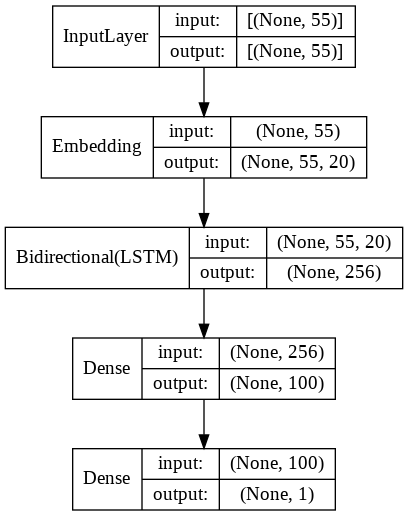

In [80]:
word_in1 = Input(shape=(tweet_max_len))
emb_word1 = Embedding(input_dim=len(word2id), output_dim=20, mask_zero=True)(word_in1)
lstm1 = Bidirectional(LSTM(units=128, return_sequences=False, recurrent_dropout=0.2))(emb_word1)
lin1 = Dense(100, activation="relu")(lstm1)
out1 = Dense(1, activation="sigmoid")(lin1)

model1 = Model(inputs=word_in1, outputs=out1)

optimizer1 = optimizers.Adam(learning_rate=0.001)
model1.compile(optimizer=optimizer1, loss="binary_crossentropy", 
              metrics = [Precision(), Recall(), Accuracy()])

plot_model(model1, show_shapes=True, show_layer_names=False)

In [81]:
model1.fit(X_train, class_train, validation_data=(X_test, class_test), batch_size=128, epochs=3, verbose=1)

Epoch 1/3
1418/1418 [==============================] - 736s 515ms/step - loss: 0.6406 - precision_9: 0.6236 - recall_9: 0.5662 - accuracy: 0.0000e+00 - val_loss: 0.6158 - val_precision_9: 0.6477 - val_recall_9: 0.5928 - val_accuracy: 0.0000e+00
Epoch 2/3
1418/1418 [==============================] - 731s 516ms/step - loss: 0.6131 - precision_9: 0.6503 - recall_9: 0.5950 - accuracy: 0.0000e+00 - val_loss: 0.6039 - val_precision_9: 0.6655 - val_recall_9: 0.5750 - val_accuracy: 0.0000e+00
Epoch 3/3
1418/1418 [==============================] - 725s 511ms/step - loss: 0.6020 - precision_9: 0.6600 - recall_9: 0.6087 - accuracy: 0.0000e+00 - val_loss: 0.5958 - val_precision_9: 0.6726 - val_recall_9: 0.5963 - val_accuracy: 0.0000e+00


II вариант: предобученные эмбединги weights -> biLSTM -> линейный слой -> выходной слой

In [107]:
!wget http://vectors.nlpl.eu/repository/20/213.zip

--2021-02-23 18:19:20--  http://vectors.nlpl.eu/repository/20/213.zip
Resolving vectors.nlpl.eu (vectors.nlpl.eu)... 129.240.189.181
Connecting to vectors.nlpl.eu (vectors.nlpl.eu)|129.240.189.181|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1485270300 (1.4G) [application/zip]
Saving to: ‘213.zip’

213.zip             100%[===================>]   1.38G  9.77MB/s    in 2m 28s  

2021-02-23 18:21:50 (9.55 MB/s) - ‘213.zip’ saved [1485270300/1485270300]



In [108]:
!unzip 213.zip

Archive:  213.zip
  inflating: meta.json               
  inflating: model.model             
  inflating: model.model.vectors_ngrams.npy  
  inflating: model.model.vectors.npy  
  inflating: model.model.vectors_vocab.npy  
  inflating: README                  


In [22]:
!pip install gensim --upgrade

Requirement already up-to-date: gensim in /usr/local/lib/python3.6/dist-packages (3.8.3)


In [27]:
import gensim
from gensim.models import KeyedVectors

In [28]:
gensim.__version__

'3.8.3'

In [29]:
vec_model_file = 'model.model'
vec_model = KeyedVectors.load(vec_model_file)

In [30]:
vec_model['мама'].shape

(300,)

In [31]:
'зарелизиля' in vec_model

True

In [32]:
#weights = np.zeros((len(word2id), 300))
weights = {0: np.zeros(300), 1: np.zeros(300)}
for i in range(2, len(id2word)):
    word = id2word[i]
    vec = vec_model[word]
    weights[i] = vec

In [33]:
len(weights) == len(word2id)

True

In [41]:
weights_matrix = np.array(list(weights.values()))
weights_matrix.shape

(15276, 300)

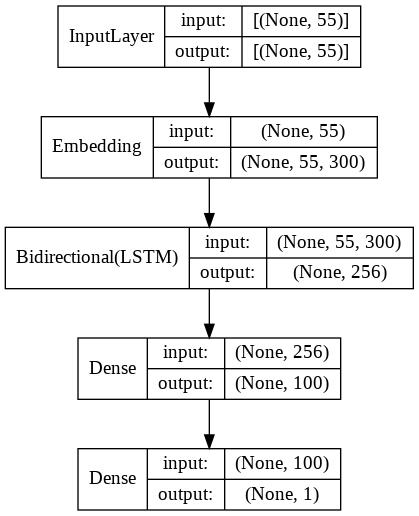

In [43]:
word_in2 = Input(shape=(tweet_max_len))
emb_word2 = Embedding(input_dim=len(word2id), output_dim=300, trainable=False, weights=[weights_matrix])(word_in2)
lstm2 = Bidirectional(LSTM(units=128, return_sequences=False, recurrent_dropout=0.2))(emb_word2)
lin2 = Dense(100, activation="relu")(lstm2)
out2 = Dense(1, activation="sigmoid")(lin2)

model2 = Model(inputs=word_in2, outputs=out2)

optimizer2 = optimizers.Adam(learning_rate=0.001)
model2.compile(optimizer=optimizer2, loss="binary_crossentropy", 
              metrics = [Precision(), Recall(), Accuracy()])

plot_model(model2, show_shapes=True, show_layer_names=False)

In [45]:
model2.fit(X_train, class_train, validation_data=(X_test, class_test), batch_size=128, epochs=3, verbose=1)

Epoch 1/3
1418/1418 [==============================] - 1083s 760ms/step - loss: 0.6397 - precision: 0.6198 - recall: 0.5611 - accuracy: 0.0000e+00 - val_loss: 0.5994 - val_precision: 0.6907 - val_recall: 0.5502 - val_accuracy: 0.0000e+00
Epoch 2/3
1418/1418 [==============================] - 1073s 757ms/step - loss: 0.5945 - precision: 0.6628 - recall: 0.6344 - accuracy: 0.0000e+00 - val_loss: 0.5754 - val_precision: 0.6591 - val_recall: 0.7342 - val_accuracy: 0.0000e+00
Epoch 3/3
1418/1418 [==============================] - 1086s 766ms/step - loss: 0.5703 - precision: 0.6823 - recall: 0.6909 - accuracy: 0.0000e+00 - val_loss: 0.5539 - val_precision: 0.6996 - val_recall: 0.6936 - val_accuracy: 0.0000e+00


III вариант: fasttext эмбеддинги обучаются на всем корпусе с нуля -> biLSTM -> линейный слой -> выходной слой

https://stackoverflow.com/questions/62743531/using-gensim-fasttext-model-with-lstm-nn-in-keras

In [46]:
from gensim.models import FastText

In [47]:
texts = [text.split() for text in data.prep_text]
ft_model = FastText(sentences=texts, size=100, window=3, iter=3, min_count=5)
#ft_emb = np.zeros((len(word2id), 100))

In [48]:
ft_weights = {0: np.zeros(100), 1: np.zeros(100)}
for i in range(2, len(id2word)):
    word = id2word[i]
    vec = ft_model.wv[word]
    ft_weights[i] = vec

ft_weights_matrix = np.array(list(ft_weights.values()))
ft_weights_matrix.shape

(15276, 100)

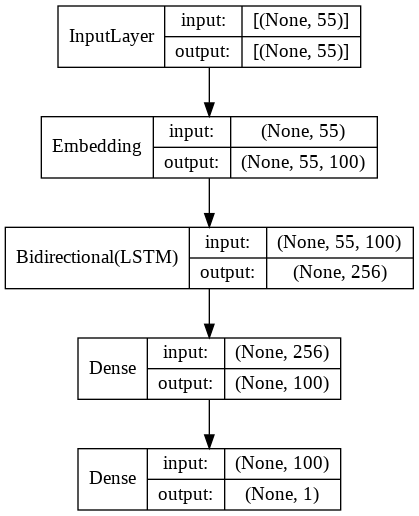

In [49]:
word_in3 = Input(shape=(tweet_max_len))
emb_word3 = Embedding(input_dim=len(word2id), output_dim=100, trainable=False, weights=[ft_weights_matrix])(word_in3)
lstm3 = Bidirectional(LSTM(units=128, return_sequences=False, recurrent_dropout=0.2))(emb_word3)
lin3 = Dense(100, activation="relu")(lstm3)
out3 = Dense(1, activation="sigmoid")(lin3)

model3 = Model(inputs=word_in3, outputs=out3)

optimizer3 = optimizers.Adam(learning_rate=0.001)
model3.compile(optimizer=optimizer3, loss="binary_crossentropy", 
              metrics = [Precision(), Recall(), Accuracy()])

plot_model(model3, show_shapes=True, show_layer_names=False)

In [50]:
model3.fit(X_train, class_train, validation_data=(X_test, class_test), batch_size=128, epochs=3, verbose=1)

Epoch 1/3
1418/1418 [==============================] - 740s 519ms/step - loss: 0.6408 - precision_1: 0.6081 - recall_1: 0.5430 - accuracy: 0.0000e+00 - val_loss: 0.5947 - val_precision_1: 0.6687 - val_recall_1: 0.6227 - val_accuracy: 0.0000e+00
Epoch 2/3
1418/1418 [==============================] - 736s 519ms/step - loss: 0.5861 - precision_1: 0.6740 - recall_1: 0.6637 - accuracy: 0.0000e+00 - val_loss: 0.5656 - val_precision_1: 0.7331 - val_recall_1: 0.5893 - val_accuracy: 0.0000e+00
Epoch 3/3
1418/1418 [==============================] - 736s 519ms/step - loss: 0.5573 - precision_1: 0.6991 - recall_1: 0.6972 - accuracy: 0.0000e+00 - val_loss: 0.5476 - val_precision_1: 0.7058 - val_recall_1: 0.7051 - val_accuracy: 0.0000e+00


По метрикам лучше всего себя показал III вариант, на следующем шаге будем использовать именно его

### Архитектура с двумя входами

эмбеддинги -> biLSTM

CharCNN -> biLSTM

выходы обеих biLSTM конкатенируются -> линейный слой -> выходной слой

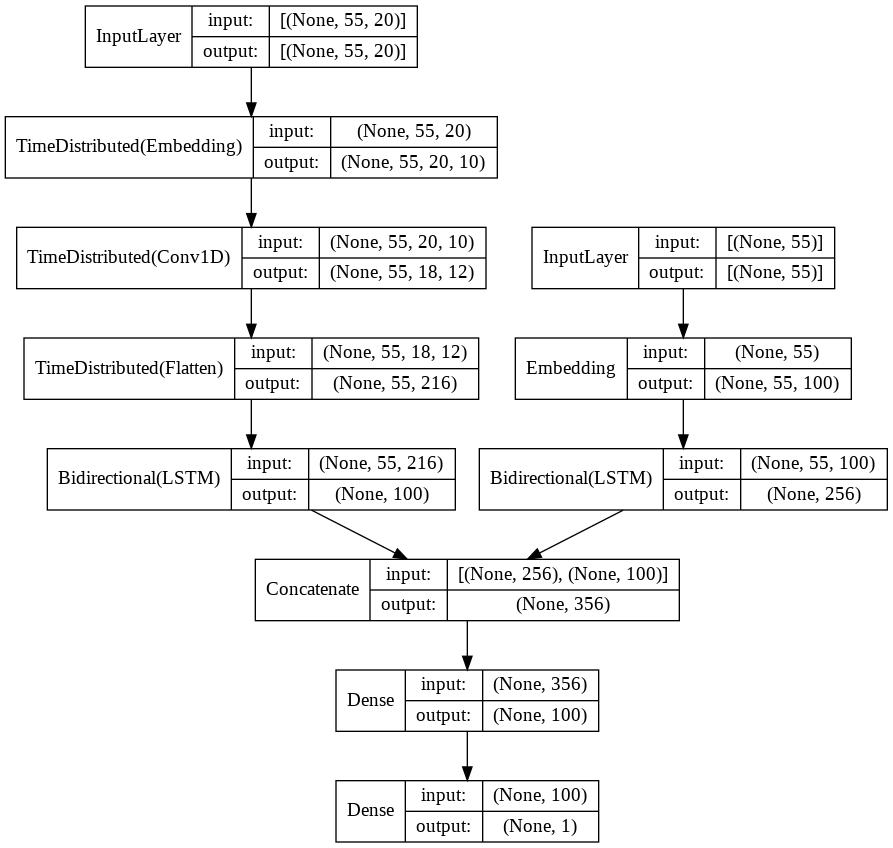

In [55]:
# один вход для слов
word_in = Input(shape=(tweet_max_len))
emb_word = Embedding(input_dim=len(word2id), output_dim=100, trainable=False, weights=[ft_weights_matrix])(word_in)
word_lstm = Bidirectional(LSTM(units=128, return_sequences=False,
                               recurrent_dropout=0.2))(emb_word)

# другой вход для символов
char_in = Input(shape=(tweet_max_len, char_max_len))
emb_char = TimeDistributed(Embedding(input_dim=len(char2id), output_dim=10, input_length=char_max_len))(char_in)
# свертка на символах (CharCNN) применяется к каждому слову отдельно
char_enc = TimeDistributed(Conv1D(filters=12, kernel_size=3))(emb_char)
char_flat = TimeDistributed(Flatten())(char_enc)
char_lstm = Bidirectional(LSTM(units=50, return_sequences=False,
                               recurrent_dropout=0.2))(char_flat)

x = concatenate([word_lstm, char_lstm])
lin = Dense(100, activation="relu")(x)
out = Dense(1, activation="sigmoid")(lin)

model = Model(inputs=[char_in, word_in], outputs=out)


optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="binary_crossentropy",
               metrics = [Precision(), Recall(), Accuracy()])
plot_model(model, show_shapes=True, show_layer_names=False)

In [ ]:
model.fit([X_char_train, X_train], class_train, validation_data=([X_char_test, X_test], class_test), batch_size=128, epochs=3, verbose=1)

Epoch 1/3
 199/1418 [===>..........................] - ETA: 17:01 - loss: 0.6737 - precision_3: 0.5600 - recall_3: 0.5449 - accuracy: 0.0000e+00